#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/all.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
6639,28/07/2022,36.389999,36.439999,35.380001,36.020000,36.020000,1622984.0,1.35,2.5,125.0
6640,29/07/2022,36.400002,36.400002,35.259998,35.299999,35.299999,1999143.0,1.35,2.5,125.0
6641,1/08/2022,35.349998,35.549999,35.099998,35.209999,35.209999,1910979.0,1.35,2.5,125.0
6642,2/08/2022,35.119999,35.450001,34.840000,35.320000,35.320000,2274146.0,1.35,2.5,125.0
6643,3/08/2022,35.320000,35.709999,35.169998,35.680000,35.680000,222870.0,1.85,2.5,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.all.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.all.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.all.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.all.delete_one(
    {'Date': last_date}
)



DELETE: 29/08/2022 35.099998474121094


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.all.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 26/08/2022 35.959999084472656
Previous last date in MongoDb: 26-08-2022. Today's date: 01-09-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'ALL.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-26,36.240002,35.650002,36.009998,35.959999,1035840,35.959999
2022-08-29,35.290001,34.639999,35.000000,35.099998,1302037,35.099998
2022-08-30,35.529999,35.020000,35.299999,35.299999,1486236,35.299999
2022-08-31,35.799999,35.110001,35.110001,35.700001,2122601,35.700001


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,35.290001,34.639999,35.000000,35.099998,1302037,35.099998
2022-08-30,35.529999,35.020000,35.299999,35.299999,1486236,35.299999
2022-08-31,35.799999,35.110001,35.110001,35.700001,2122601,35.700001


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_10376/307716900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_10376/307716900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_10376/307716900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,35.290001,34.639999,35.000000,35.099998,1302037,35.099998,1.85,2.5,125
1,30/08/2022,35.529999,35.020000,35.299999,35.299999,1486236,35.299999,1.85,2.5,125
2,31/08/2022,35.799999,35.110001,35.110001,35.700001,2122601,35.700001,1.85,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/08/2022',
  'High': 35.290000915527344,
  'Low': 34.63999938964844,
  'Open': 35.0,
  'Close': 35.099998474121094,
  'Volume': 1302037,
  'Adj Close': 35.099998474121094,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '30/08/2022',
  'High': 35.529998779296875,
  'Low': 35.02000045776367,
  'Open': 35.29999923706055,
  'Close': 35.29999923706055,
  'Volume': 1486236,
  'Adj Close': 35.29999923706055,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '31/08/2022',
  'High': 35.79999923706055,
  'Low': 35.11000061035156,
  'Open': 35.11000061035156,
  'Close': 35.70000076293945,
  'Volume': 2122601,
  'Adj Close': 35.70000076293945,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125}]

In [10]:
#INSERT NEW DATA INTO MONGODB
db.all.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.all.find()))

last_vals = df_mongo.iloc[-10:].values
print(last_vals)

[[ObjectId('62ff3d91531e1e0a184616e3') '18/08/2022' 36.599998474121094
  36.66999816894531 36.11000061035156 36.25 36.25 1373026.0 1.85 2.5
  125.0]
 [ObjectId('630332c6b33ab07a7e66cbde') '19/08/2022' 36.20000076293945
  36.56999969482422 36.16999816894531 36.349998474121094
  36.349998474121094 1360866.0 1.85 2.5 125.0]
 [ObjectId('63049c75b33ab07a7e66cbe3') '22/08/2022' 36.0099983215332
  36.15999984741211 35.11000061035156 35.380001068115234
  35.380001068115234 1165566.0 1.85 2.5 125.0]
 [ObjectId('630725c3a25ac8ff42c58e29') '23/08/2022' 35.09000015258789
  35.31999969482422 34.81999969482422 34.93000030517578 34.93000030517578
  1402443.0 1.85 2.5 125.0]
 [ObjectId('630725c3a25ac8ff42c58e2a') '24/08/2022' 35.4900016784668
  36.04999923706055 35.439998626708984 35.59000015258789
  35.59000015258789 1654892.0 1.85 2.5 125.0]
 [ObjectId('630ae52925ef5744fd645d2d') '25/08/2022' 35.689998626708984
  36.130001068115234 35.11000061035156 36.0 36.0 1156021.0 1.85 2.5 125.0]
 [ObjectId('63

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_val,last_date,last_close)

[[ObjectId('630ff93b41269e1989242177') '31/08/2022' 35.11000061035156
  35.79999923706055 35.11000061035156 35.70000076293945 35.70000076293945
  2122601.0 1.85 2.5 125.0]] 31/08/2022 35.70000076293945


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.all.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(6603, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(5283, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00286563, 0.00286563, 0.00286563, 0.00286563,
       0.00286563, 0.00479341, 0.00479341, 0.00479341, 0.00479341,
       0.00479341, 0.00479341, 0.00479341, 0.00479341, 0.00479341,
       0.00479341, 0.00479341, 0.00479341, 0.00479341, 0.00479341,
       0.00479341, 0.00479341, 0.00479341, 0.00479341, 0.00479341])]
[0.004793414365516892]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(5223, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(5223, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

5223/5223 [==============================] - 329s 63ms/step - loss: 1.3133e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.6666963380528307

C:\Users\antoi\AppData\Local\Temp/ipykernel_10376/4154416992.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


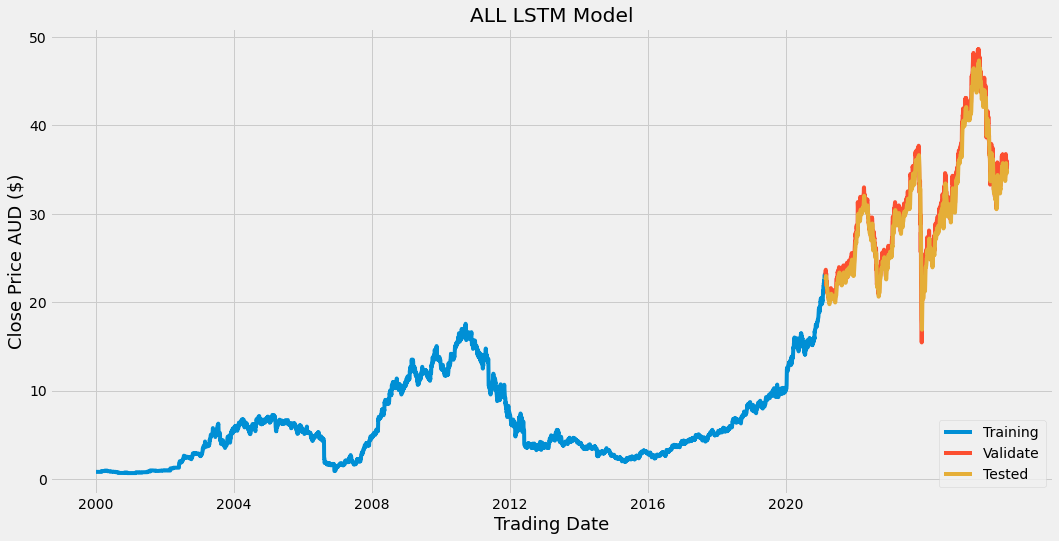

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('ALL LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/all_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_10376/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
5283  23.100000    22.514273    0.585727
5284  23.080000    22.552820    0.527180
5285  23.200001    22.546074    0.653927
5286  23.430000    22.564289    0.865711
5287  23.559999    22.661217    0.898782
...         ...          ...         ...
6598  36.000000    34.553505    1.446495
6599  35.959999    34.706608    1.253391
6600  35.099998    34.932339    0.167660
6601  35.299999    34.825981    0.474018
6602  35.700001    34.719147    0.980854

[1320 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.all.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

31/08/2022 Last close $35.70000076293945 Predicted next day share price $34.33


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/all_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list all_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/all_model.sav')

In [32]:
# query the all collection and load into dataframe

df_mongo = pd.DataFrame(list(db.all.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[33.66      ],
       [34.209999  ],
       [34.099998  ],
       [32.860001  ],
       [33.        ],
       [32.810001  ],
       [31.18      ],
       [32.950001  ],
       [33.43      ],
       [33.07      ],
       [33.009998  ],
       [32.689999  ],
       [34.299999  ],
       [33.959999  ],
       [33.869999  ],
       [34.380001  ],
       [34.389999  ],
       [34.509998  ],
       [34.549999  ],
       [34.759998  ],
       [35.93      ],
       [36.25      ],
       [35.419998  ],
       [35.5       ],
       [35.349998  ],
       [36.060001  ],
       [35.959999  ],
       [36.509998  ],
       [35.470001  ],
       [35.939999  ],
       [36.040001  ],
       [35.900002  ],
       [35.919998  ],
       [35.380001  ],
       [35.310001  ],
       [35.380001  ],
       [35.259998  ],
       [35.099998  ],
       [34.84      ],
       [34.45000076],
       [34.90000153],
       [34.75      ],
       [33.93000031],
       [33.81999969],
       [33.99000168],
       [34

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/all_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_all(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_all(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[34.96,
 34.96,
 34.95,
 34.93,
 34.91,
 34.89,
 34.86,
 34.86,
 34.84,
 34.82,
 34.8,
 34.78,
 34.79,
 34.77,
 34.77,
 34.76,
 34.75,
 34.75,
 34.74,
 34.73,
 34.73,
 34.72,
 34.71,
 34.7,
 34.69,
 34.69,
 34.68,
 34.67,
 34.66,
 34.66,
 34.65,
 34.64,
 34.63,
 34.63,
 34.62,
 34.61,
 34.61,
 34.6,
 34.59,
 34.59,
 34.58,
 34.57,
 34.57,
 34.56,
 34.56,
 34.57,
 34.58,
 34.58,
 34.59,
 34.59,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.61,
 34.61,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.6,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.59,
 34.5

In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  02-09-2022     Friday
1        2  05-09-2022     Monday
2        3  06-09-2022    Tuesday
3        4  07-09-2022  Wednesday
4        5  08-09-2022   Thursday
..     ...         ...        ...
203    204  14-06-2023  Wednesday
204    205  15-06-2023   Thursday
205    206  16-06-2023     Friday
206    207  19-06-2023     Monday
207    208  20-06-2023    Tuesday

[208 rows x 3 columns]>


In [35]:
today4 = date.today()
d=today4+timedelta(days=1)
d=d.strftime('%d-%m-%Y')
print("Today plus one day:   "+d)


#Check if mongoDb now has latest data
dates_df_mongo = pd.DataFrame(list(db.dates.find()))
d_mdb = dates_df_mongo.iloc[0,2]
print("Predicted next date in mongodb:   "+d_mdb)

# print(d,d_mdb)



def update_date():
    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_mongo = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_mongo.iloc[:,1:].values
    return dates_val

if d==d_mdb:
    print("Awesome! dates are already correctly updated!")
else:
    print("Dates need to be updated"+d+"  "+d_mdb)
    dates_val = update_date()
    print(dates_val)

Today plus one day:   02-09-2022
Predicted next date in mongodb:   31-08-2022
Dates need to be updated02-09-2022  31-08-2022
[[1 '02-09-2022' 'Friday']
 [2 '05-09-2022' 'Monday']
 [3 '06-09-2022' 'Tuesday']
 [4 '07-09-2022' 'Wednesday']
 [5 '08-09-2022' 'Thursday']
 [6 '09-09-2022' 'Friday']
 [7 '12-09-2022' 'Monday']
 [8 '13-09-2022' 'Tuesday']
 [9 '14-09-2022' 'Wednesday']
 [10 '15-09-2022' 'Thursday']
 [11 '16-09-2022' 'Friday']
 [12 '19-09-2022' 'Monday']
 [13 '20-09-2022' 'Tuesday']
 [14 '21-09-2022' 'Wednesday']
 [15 '22-09-2022' 'Thursday']
 [16 '23-09-2022' 'Friday']
 [17 '26-09-2022' 'Monday']
 [18 '27-09-2022' 'Tuesday']
 [19 '28-09-2022' 'Wednesday']
 [20 '29-09-2022' 'Thursday']
 [21 '30-09-2022' 'Friday']
 [22 '03-10-2022' 'Monday']
 [23 '04-10-2022' 'Tuesday']
 [24 '05-10-2022' 'Wednesday']
 [25 '06-10-2022' 'Thursday']
 [26 '07-10-2022' 'Friday']
 [27 '10-10-2022' 'Monday']
 [28 '11-10-2022' 'Tuesday']
 [29 '12-10-2022' 'Wednesday']
 [30 '13-10-2022' 'Thursday']
 [31 '14

In [36]:
dates_df

,Count,Date,DOW
0,1,02-09-2022,Friday
1,2,05-09-2022,Monday
2,3,06-09-2022,Tuesday
3,4,07-09-2022,Wednesday
4,5,08-09-2022,Thursday
...,...,...,...
203,204,14-06-2023,Wednesday
204,205,15-06-2023,Thursday
205,206,16-06-2023,Friday
206,207,19-06-2023,Monday


In [37]:
day1=dates_df.iloc[0,1]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,1]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,1]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,1]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,1]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,1]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,1]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,1]+" "+dates_df.iloc[7,2]

C:\Users\antoi\AppData\Local\Temp/ipykernel_10376/2507289043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


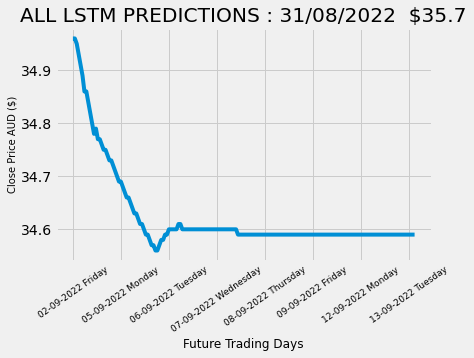

In [38]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('ALL LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=12)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/all_pred.png', bbox_inches="tight")
plt.show()

In [39]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'Count': 1, 'Date': '02-09-2022', 'DOW': 'Friday', 'Price': 34.96}


In [40]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


5283 6603 6763


C:\Users\antoi\AppData\Local\Temp/ipykernel_10376/3391947158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


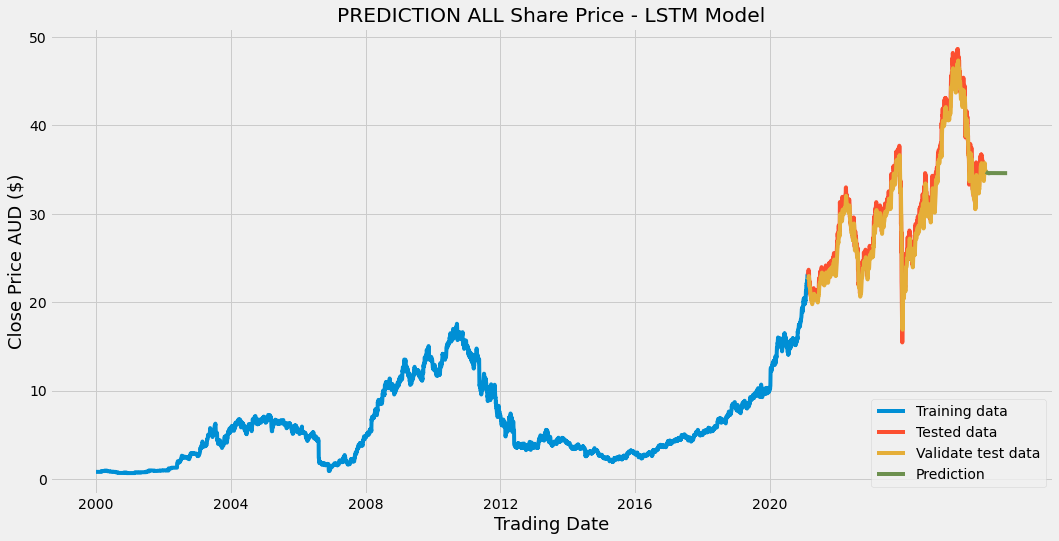

In [41]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION ALL Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/all_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [42]:
# Query all
name = 'ALL'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

print(today)

{'_id': ObjectId('63083b64cd3920ce081aa1ec'), 'model': 'RFR', 'name': 'ALL', 'date': '25/08/2022', 'predicted': 31, 'actual': 36, 'difference': -4.9502, 'accuracy': 94.04}
{'_id': ObjectId('630dc686ae0967d012939328'), 'model': 'LSTM', 'name': 'ALL', 'date': '30/08/2022', 'predicted': 34.34, 'actual': 35.3, 'difference': -0.96, 'rmse': 0.65113}
01-09-2022


In [43]:
print(today,last_date)

01-09-2022 31/08/2022


In [44]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('63083b64cd3920ce081aa1ec'), 'model': 'RFR', 'name': 'ALL', 'date': '25/08/2022', 'predicted': 31, 'actual': 36, 'difference': -4.9502, 'accuracy': 94.04}


In [45]:
# Set keys and values of company
name = 'ALL'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'INSERT: date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

INSERT: date 31/08/2022,predicted $34.33, actual $35.7, difference -1.3700000000000045, rmse 0.6667


In [46]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the companys collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('63083b64cd3920ce081aa1ec'), 'model': 'RFR', 'name': 'ALL', 'date': '25/08/2022', 'predicted': 31, 'actual': 36, 'difference': -4.9502, 'accuracy': 94.04}
{'_id': ObjectId('630ffb2e41269e1989242249'), 'model': 'LSTM', 'name': 'ALL', 'date': '31/08/2022', 'predicted': 34.33, 'actual': 35.7, 'difference': -1.37, 'rmse': 0.6667}


In [47]:
# query all companys_agg collection
companys = db.companys_agg.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62ec4de61cfb4e6d9db0dc79'), 'model': 'LSTM', 'name': 'ALL', 'date': '04/08/2022', 'predicted': 33, 'actual': 35.12, 'difference': -2.12, 'rmse': 1.30634}
{'_id': ObjectId('62eccf65ba8998cd29835929'), 'model': 'LSTM', 'name': 'ALL', 'date': '05/08/2022', 'predicted': 36, 'actual': 35.12, 'difference': 0.88, 'rmse': 1.69207}
{'_id': ObjectId('62f0bc516eb9c30ce4d6de07'), 'model': 'LSTM', 'name': 'ALL', 'date': '08/08/2022', 'predicted': 33, 'actual': 34.06, 'difference': -1.06, 'rmse': 0.46389}
{'_id': ObjectId('62f2053fe6ee820708a522a7'), 'model': 'LSTM', 'name': 'ALL', 'date': '09/08/2022', 'predicted': 34, 'actual': 34.53, 'difference': -0.53, 'rmse': 0.20756}
{'_id': ObjectId('62f36b45c0c176a3a2f03719'), 'model': 'LSTM', 'name': 'ALL', 'date': '10/08/2022', 'predicted': 33, 'actual': 34.11, 'difference': -1.11, 'rmse': 0.14037}
{'_id': ObjectId('62f9fbbf536671c90f137c73'), 'model': 'LSTM', 'name': 'ALL', 'date': '15/08/2022', 'predicted': 33.65, 'actual': 35.64, 'dif

In [48]:
# # Delete a document from a collection
# duplicate_date ="12/08/2022"
# db.companys_agg.delete_one(
#     {'model': 'LSTM','name': name,'date':duplicate_date}
# )